## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

MM19JV 
Jordan Vauls

In [9]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from skimage import io, transform
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2
import shutil
from PIL import Image
from torch import optim
import timeit

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [10]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [11]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)   
    return paths, classes

Now we create a dataframe using all the data.

In [12]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)
data = {
    'path': paths,
    'class': classes
}
data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) 

### Rotating images.

In [28]:

def rotationoftheimage(path):
    angles, image = [90], Image.open(path) # Add more rotations to angles if desired.
    for i in angles:
        image = image.rotate(i, expand=1)
        image.save(path[:-5] + '(' + str(i) + ').JPEG')
    image.close()
shutil.copytree('imagenet10/train_set', 'imagenet10/new_training_set') # new_training_set must not exist! 
directory_rotation = "imagenet10/new_training_set/" 
paths2, classes2 = get_meta(directory_rotation, class_names)
for i in range(len(data_df)):
    rotationoftheimage(paths2[i])
paths2, classes2 = get_meta(directory_rotation, class_names)
data2 = {'path': paths2, 'class': classes2}
data_df = pd.DataFrame(data2, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data
print('Duplication and rotation complete.')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'imagenet10/new_training_set'

In [15]:

class ImageNet10(Dataset):
    """ ImageNet10 dataset. """
    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))
        if self.transform:
            x = self.transform(x)
        return x, y

In [16]:

def compute_img_mean_std(image_paths):
    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)
    imgs = imgs.astype(np.float32) / 255.
    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))
    means.reverse()  # BGR --> RGB
    stdevs.reverse()
    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [17]:
#norm_mean, norm_std = compute_img_mean_std(paths)

In [18]:
norm_mean, norm_std = compute_img_mean_std(paths2)

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [01:19<00:00, 226.57it/s]


(224, 224, 3, 18000)
normMean = [0.5227935, 0.4798399, 0.4063444]
normStd = [0.29729712, 0.28864047, 0.31117702]


Now let's create the transforms to normalise and turn our data into tensors.

In [19]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [20]:
    ## train size and valid size.
    train_split = 0.70 # Defines the ratio of train/valid/test data.
    valid_split = 0.10
    
    ## train size specified.
    train_size = int(len(data_df)*train_split)
    valid_size = int(len(data_df)*valid_split)
    
    ## making the training sets.
    ins_dataset_train = ImageNet10(
        df=data_df[:train_size],
        transform=data_transform,
    )
    ins_dataset_valid = ImageNet10(
        df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
        transform=data_transform,
    )
    ins_dataset_test = ImageNet10(
        df=data_df[(train_size + valid_size):].reset_index(drop=True),
        transform=data_transform,
    )

You will need to create DataLoaders for the datasets.

In [21]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers = 0 
)
test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers = 0
)
valid_loader = torch.utils.data.DataLoader(
    ins_dataset_valid,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers = 0
)
classes = np.arange(0, 10)

A framework for the ConvNet model, missing all layers except the final fully-connected layer:

### Creating the neural network.

In [22]:

## defining the neural network..
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = 2, stride = 2), 
                                   nn.Dropout(p = 0.3))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 24, 4), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = 2, stride = 2), 
                                   nn.Dropout(p = 0.3))
        self.conv3 = nn.Sequential(nn.Conv2d(24, 32, 4), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = 2, stride = 2), 
                                   nn.Dropout(p = 0.3))
        self.conv4 = nn.Sequential(nn.Conv2d(32, 40, 4), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = 2, stride = 2), 
                                   nn.Dropout(p = 0.3))
        self.conv5 = nn.Sequential(nn.Conv2d(40, 48, 4), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size = 2, stride = 2), 
                                   nn.Dropout(p = 0.3))
        self.fc1 = nn.Linear(1200, 512)
        self.fc2 = nn.Linear(512, num_classes)
## forward pass.
    def forward(self, y):
        out = self.conv1(y)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

torch.manual_seed(0)

### Setting the device to GPU 

In [23]:
## Setting the device as GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### Setting the model to gpu/stating optimizer

In [24]:
##emptying memory.
torch.cuda.empty_cache()
##settingalgorithim.
criterion = nn.CrossEntropyLoss()
## setting model to gpu
model = ConvNet().to(device)
## setting the optimizer.
optimizer = optim.SGD(model.parameters(), lr=0.0015, momentum=0.9)

### Accuracy module.

In [25]:
def accu_mod():
    with torch.no_grad():
        global correct
        global total
        accuracy = 0
        validation_loss = 0 
        model.eval()
        for images, labels in valid_loader:
            #accuracy
            #images, labels = data
            images = images.to(device)  # missing line from original code
            labels = labels.to(device)
            outputs = model(images)
            # torch.max is an argmax operation
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Loss
            logps = model.forward(images)
            batch_loss = criterion(logps, labels)
            validation_loss += batch_loss.item() 
    model.train()
    return (100 * correct / total), (validation_loss / len(valid_loader))


### Train models

In [26]:
correct = 0
total = 0

def train_model_epochs2(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device 
        during training. 
    """
    epochlevel = 0
    global model
    global bestmodel
    lowestval = 100
    train_losses, validation_losses, valid_accu = [], [], []
    """
    print("Saving Filter before...")
    filters = Filts(model.cpu())
    fig = showFilters(filters[0])
    fig.savefig('FilterVisualisationBefore' + '.png', bbox_inches='tight')
    model = model.to(device)
    """  
    for epoch in range(num_epochs):
        """
        if epoch == (num_epochs/2):
            print("Saving Filter Midway...")
            filters = Filts(model.cpu())
            fig = showFilters(filters[0])
            fig.savefig('FilterVisualisationMidway' + '.png', bbox_inches='tight')
            model = model.to(device)
        """
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:    # print every 1000 mini-batches
                print('Epoch / Batch [%d / %d]' %
                      (epoch + 1, i + 1))
                #running_loss = 0.0
        # Validation data
        validation_accuracy, validation_loss = accu_mod()
        if validation_loss < lowestval:
            bestmodel = model 
            epochlevel = epoch + 1   
            print("best model found: ", bestmodel.fc1.weight)
            print("Saving Validation ","Original: ", validation_loss, "Lowest Value: ", lowestval)
            print("epoch level:", epochlevel)
            lowestval = validation_loss       
        running_loss = running_loss / len(train_loader)
        train_losses.append(running_loss)
        validation_losses.append(validation_loss) 
        valid_accu.append(validation_accuracy)
        
        print(f"-------------------------------- \n"
              f"  Epoch {epoch+1}/{num_epochs} \n"
              f"  Train loss: {running_loss:.3f} \n"
              f"  Validation loss: {validation_loss:.3f} \n"
              f"  Validation accuracy: {validation_accuracy:.3f}% \n"
              f"--------------------------------")
        model.train()
    """   
    print("Saving Filter after...")
    filters = Filts(model.cpu())
    fig = showFilters(filters[0])
    fig.savefig('FilterVisualisationEND' + '.png', bbox_inches='tight')  
    model = model.to(device)
    """   
    print("Lowest Validation: ", lowestval, "epoch level:", epochlevel)
    plt.plot(train_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    print("Train losses")
    print(train_losses)
    print("Validation losses")
    print(validation_losses)
    plt.plot(valid_accu, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()
    print("Validation Accuracy")
    print(valid_accu)

### CPU Train.

Epoch / Batch [1 / 10]
Epoch / Batch [1 / 20]
Epoch / Batch [1 / 30]
Epoch / Batch [1 / 40]
Epoch / Batch [1 / 50]
Epoch / Batch [1 / 60]
Epoch / Batch [1 / 70]
Epoch / Batch [1 / 80]
Epoch / Batch [1 / 90]
Epoch / Batch [1 / 100]
Epoch / Batch [1 / 110]
Epoch / Batch [1 / 120]
Epoch / Batch [1 / 130]
Epoch / Batch [1 / 140]
Epoch / Batch [1 / 150]
Epoch / Batch [1 / 160]
Epoch / Batch [1 / 170]
Epoch / Batch [1 / 180]
Epoch / Batch [1 / 190]
Epoch / Batch [1 / 200]
Epoch / Batch [1 / 210]
Epoch / Batch [1 / 220]
Epoch / Batch [1 / 230]
Epoch / Batch [1 / 240]
Epoch / Batch [1 / 250]
Epoch / Batch [1 / 260]
Epoch / Batch [1 / 270]
Epoch / Batch [1 / 280]
Epoch / Batch [1 / 290]
Epoch / Batch [1 / 300]
Epoch / Batch [1 / 310]
Epoch / Batch [1 / 320]
Epoch / Batch [1 / 330]
Epoch / Batch [1 / 340]
Epoch / Batch [1 / 350]
Epoch / Batch [1 / 360]
Epoch / Batch [1 / 370]
Epoch / Batch [1 / 380]
Epoch / Batch [1 / 390]
best model found:  Parameter containing:
tensor([[ 0.0259,  0.0092,  0.01

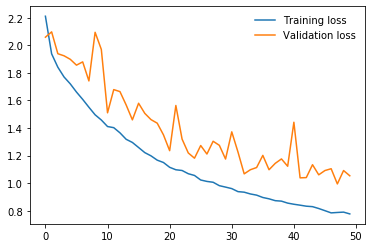

Train losses
[2.210980135172152, 1.9383810918948372, 1.8414069892186198, 1.7704638865998554, 1.7206060120902085, 1.6611386918779558, 1.6081031113106588, 1.5510630501708405, 1.4962492406670818, 1.4585199014184438, 1.411202191852676, 1.4028853152306553, 1.3654796653592647, 1.3185884684778106, 1.2957540591658674, 1.2590204307875656, 1.221967557360073, 1.1984726344873458, 1.1673189735957208, 1.15040112267896, 1.115502039036775, 1.0976492476644855, 1.0923685389121778, 1.0689358859497884, 1.0563608907200963, 1.0234130920492452, 1.0131274153133334, 1.0070088818896241, 0.9822679957762588, 0.9719010154305375, 0.9609811708406748, 0.9390945213700309, 0.9350608111486822, 0.9221768875412529, 0.9136691719747437, 0.896548506799083, 0.8868846966681747, 0.8734975313474684, 0.8701167632329282, 0.8557893027962767, 0.8475455439786621, 0.8408125988420496, 0.8334502406077942, 0.8301182492886703, 0.8166670587462217, 0.8009263195362187, 0.7849708804624335, 0.7879561713050465, 0.7904364033247614, 0.77743631291

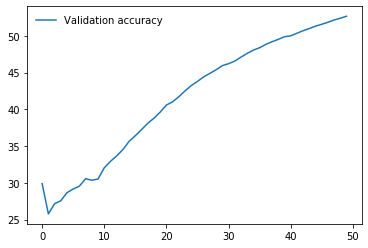

Validation Accuracy
[29.88888888888889, 25.77777777777778, 27.166666666666668, 27.569444444444443, 28.666666666666668, 29.166666666666668, 29.563492063492063, 30.569444444444443, 30.358024691358025, 30.52777777777778, 32.05555555555556, 32.93055555555556, 33.67094017094017, 34.53174603174603, 35.65555555555556, 36.416666666666664, 37.248366013071895, 38.10493827160494, 38.79824561403509, 39.625, 40.58201058201058, 41.032828282828284, 41.71497584541063, 42.511574074074076, 43.22666666666667, 43.794871794871796, 44.41975308641975, 44.8968253968254, 45.383141762452105, 45.94444444444444, 46.20609318996416, 46.5625, 47.101010101010104, 47.6078431372549, 48.05873015873016, 48.38425925925926, 48.83483483483484, 49.19736842105263, 49.51851851851852, 49.87777777777778, 50.0, 50.347883597883595, 50.695090439276484, 50.98737373737374, 51.31604938271605, 51.56884057971015, 51.843971631205676, 52.15856481481482, 52.394557823129254, 52.66555555555556]


In [27]:


cpu_train_time = timeit.timeit(
    "train_model_epochs2(num_epochs)",
    setup="num_epochs=50",
    number=1,
    globals=globals(),
)

In [29]:
cpu_train_time

6628.1286292

### Accuracy results.

In [30]:
correct = 0
total = 0
tot_labels = []
tot_pred = []
with torch.no_grad():
    # Iterate over the test set
    for images, labels in test_loader:
        images = images.to(device)  
        labels = labels.to(device)
        tot_labels.append(np.array(labels.cpu()))
        outputs = bestmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        tot_pred.append(np.array(predicted.cpu()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
tot_labels = np.array(tot_labels).flatten()
tot_pred = np.array(tot_pred).flatten()

Accuracy of the network on the test images: 65 %


### Stating the confusion matrix.

In [31]:
cm = confusion_matrix(tot_labels, tot_pred)
cm

array([[294,   3,   4,  42,   2,   0,   6,   6,   4,   0],
       [  3, 250,   6,   8,   1,   4,  15,  24,  29,  37],
       [ 16,   3, 215,   7,  10,  15,  26,  41,  23,   1],
       [ 26,   5,   2, 267,   4,   2,   5,   9,   5,   4],
       [  2,   3,   5,   0, 243,  37,  37,   2,  40,   5],
       [  3,   8,   6,   5,  25, 190,  65,  24,  20,   5],
       [ 11,   9,   7,  11,  35,  50, 194,  14,  23,   6],
       [ 20,   9,  13,  15,   6,  25,  30, 228,  33,   4],
       [  4,  18,   5,   2,  30,  20,  24,  24, 225,  14],
       [  3,  44,   2,   5,   2,   7,   4,   5,   5, 265]], dtype=int64)

### Plot the matrix code.

In [32]:
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Confusing matrix plotting

Confusion matrix, without normalization


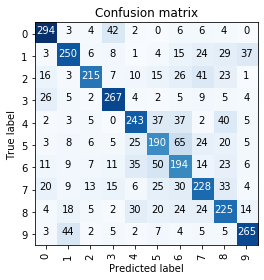

In [33]:
plot_confusion_matrix(cm, classes)

### Visualising the filters.

In [ ]:
import matplotlib.pyplot as plt
def normalize (layer):
    f_min, f_max = layer.min(), layer.max()
    return (layer - f_min) / (f_max - f_min)
def Filts(model):
    filters = [model.conv1[0].weight.data, model.conv2[0].weight.data, model.conv3[0].weight.data,model.conv4[0].weight.data,model.conv5[0].weight.data, model.fc1.weight.data, model.fc2.weight.data]
    for i, layer in enumerate(filters):
        filters[i] = normalize(filters[i])
    return filters
def showFilters (filter):
    fig = plt.figure()
    plt.figure(figsize=(22,6))
    size = filter.size()
    for idx, filt  in enumerate(filter):
        for layer in range(size[1]):
            plt.subplot(size[1],size[0], idx + 1 + size[0]*layer)
            plt.imshow(filt[layer, :, :], cmap="gray")
            plt.axis('off')  
            for i in range(3):
                for j in range(3):
                    text = ax.text(j, i, filt[layer, i, j], ha="center", va="center", color="w")
    return plt

In [ ]:
filters = Filts(model.cpu())
fig = showFilters(filters[0].cpu())
fig.savefig('FilterVisualisationBefore123' + '.png', bbox_inches='tight')


In [ ]:
from PIL import Image
img_test = Image.open("./imagenet10/train_set/baboon/n02486410_10010.JPEG")
img_test

### Visualising Features maps.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


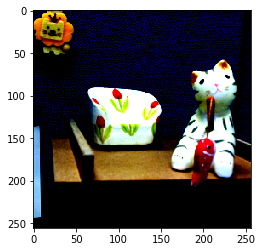

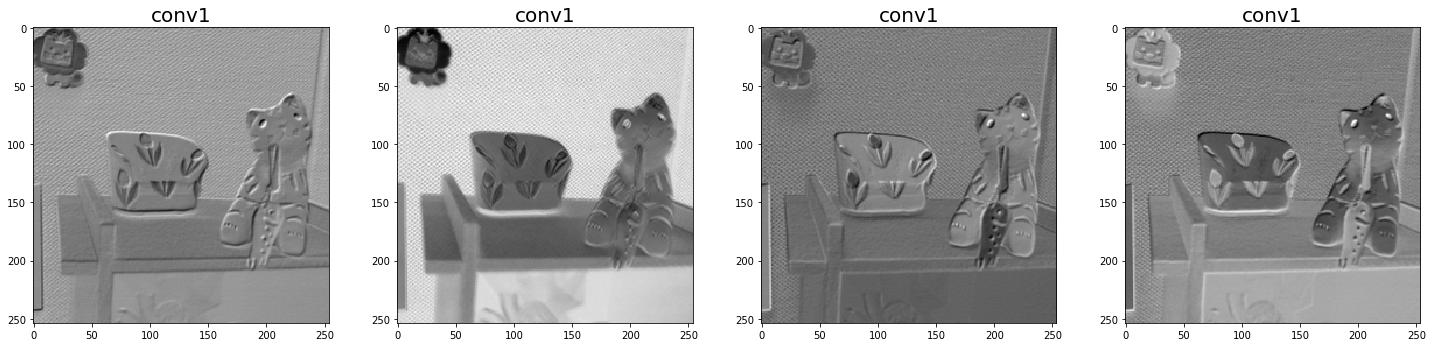

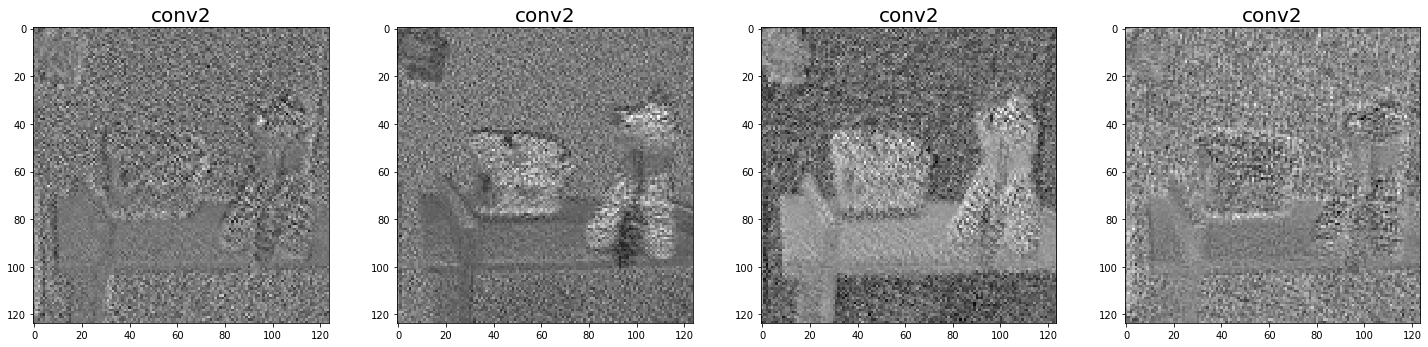

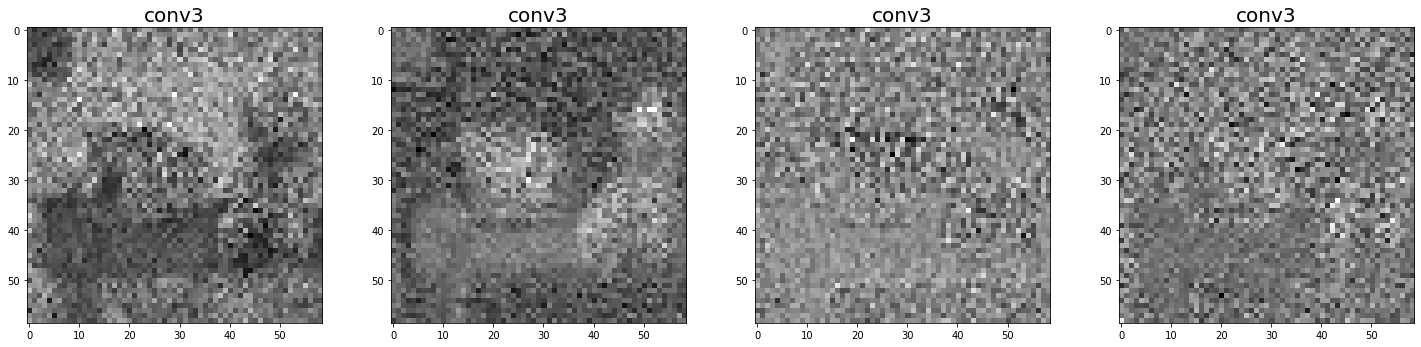

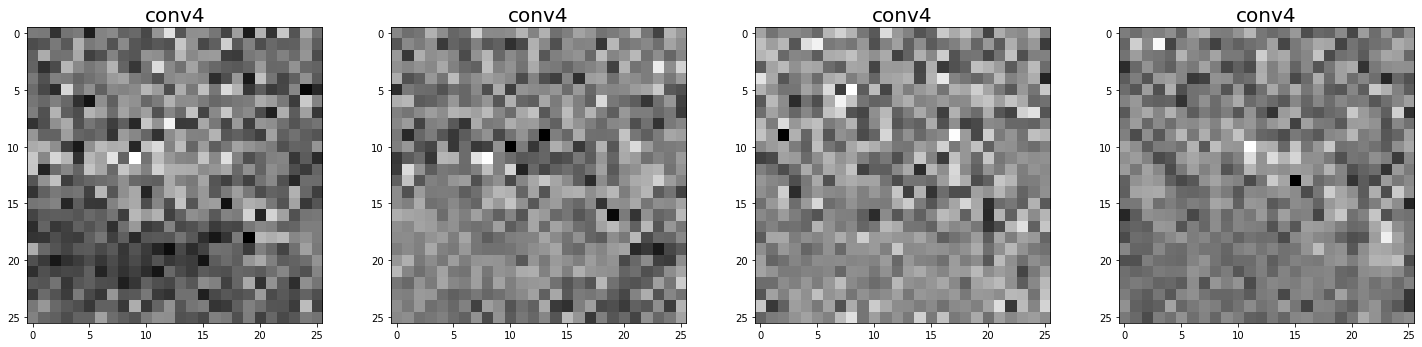

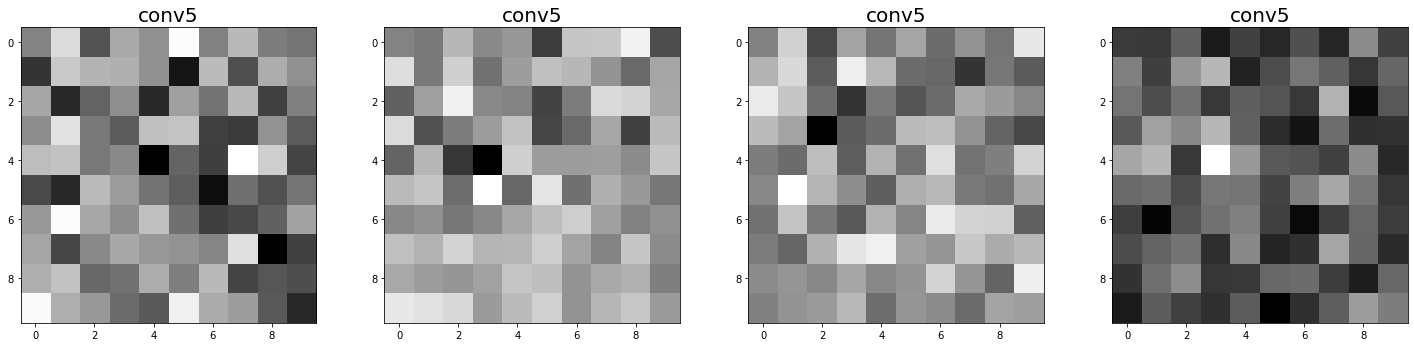

In [82]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
layers = ["conv1", "conv2", "conv3", "conv4", "conv5"]
dataiter =iter(train_loader)
images, _ = dataiter.next()
p123 = np.transpose(images[0].cpu().detach().numpy(),(1,2,0))
plt.imshow(p123)
for layer in layers:
    code = 'model.' + layer + "[0]" + ".register_forward_hook(get_activation('"+layer+"'))"
    exec(code)
    data = images[0]      
    data.unsqueeze_(0)
    output = model.cpu()
    output = model(data)
    code2 = "act =  activation['" + layer + "'].squeeze()"
    exec(code2) 
    plt.figure(figsize=(25,25))
    for idx, filt  in enumerate(act):
        if idx < 4:
            plt.subplot(4,4, idx + 1)
            plt.imshow(filt,cmap="gray")
            plt.axis('on')
            plt.title(layer, fontsize=20)
    plt.show()